In [13]:
import tensorflow as tf
from tensorflow import keras

import numpy as np

from tensorflow.keras import layers

# Create the discriminator
discriminator = keras.Sequential(
    [
        keras.Input(shape=(28, 28, 1)),
        layers.Conv2D(64, (3, 3), strides=(2, 2), padding="same"),
        layers.LeakyReLU(alpha=0.2),
        layers.Conv2D(128, (3, 3), strides=(2, 2), padding="same"),
        layers.LeakyReLU(alpha=0.2),
        layers.GlobalMaxPooling2D(),
        layers.Dense(1),
    ],
    name="discriminator",
)

# Create the generator
latent_dim = 128
generator = keras.Sequential(
    [
        keras.Input(shape=(latent_dim,)),
        # We want to generate 128 coefficients to reshape into a 7x7x128 map
        layers.Dense(7 * 7 * 128),
        layers.LeakyReLU(alpha=0.2),
        layers.Reshape((7, 7, 128)),
        layers.Conv2DTranspose(128, (4, 4), strides=(2, 2), padding="same"),
        layers.LeakyReLU(alpha=0.2),
        layers.Conv2DTranspose(128, (4, 4), strides=(2, 2), padding="same"),
        layers.LeakyReLU(alpha=0.2),
        layers.Conv2D(1, (7, 7), padding="same", activation="sigmoid"),
    ],
    name="generator",
)

class GAN(keras.Model):
    def __init__(self, discriminator, generator, latent_dim):
        super(GAN, self).__init__()
        self.discriminator = discriminator
        self.generator = generator
        self.latent_dim = latent_dim

    def compile(self, d_optimizer, g_optimizer, loss_fn):
        super(GAN, self).compile()
        self.d_optimizer = d_optimizer
        self.g_optimizer = g_optimizer
        self.loss_fn = loss_fn

    def train_step(self, real_images):
        if isinstance(real_images, tuple):
            real_images = real_images[0]
        # Sample random points in the latent space
        batch_size = tf.shape(real_images)[0]
        random_latent_vectors = tf.random.normal(shape=(batch_size, self.latent_dim))

        # Decode them to fake images
        generated_images = self.generator(random_latent_vectors)

        # Combine them with real images
        combined_images = tf.concat([generated_images, real_images], axis=0)

        # Assemble labels discriminating real from fake images
        labels = tf.concat(
            [tf.ones((batch_size, 1)), tf.zeros((batch_size, 1))], axis=0
        )
        # Add random noise to the labels - important trick!
        labels += 0.05 * tf.random.uniform(tf.shape(labels))

        # Train the discriminator
        with tf.GradientTape() as tape:
            predictions = self.discriminator(combined_images)
            d_loss = self.loss_fn(labels, predictions)
        grads = tape.gradient(d_loss, self.discriminator.trainable_weights)
        self.d_optimizer.apply_gradients(
            zip(grads, self.discriminator.trainable_weights)
        )

        # Sample random points in the latent space
        random_latent_vectors = tf.random.normal(shape=(batch_size, self.latent_dim))

        # Assemble labels that say "all real images"
        misleading_labels = tf.zeros((batch_size, 1))

        # Train the generator (note that we should *not* update the weights
        # of the discriminator)!
        with tf.GradientTape() as tape:
            predictions = self.discriminator(self.generator(random_latent_vectors))
            g_loss = self.loss_fn(misleading_labels, predictions)
        grads = tape.gradient(g_loss, self.generator.trainable_weights)
        self.g_optimizer.apply_gradients(zip(grads, self.generator.trainable_weights))
        return {"d_loss": d_loss, "g_loss": g_loss}

batch_size = 64
(x_train, _), (x_test, _) = keras.datasets.mnist.load_data()
all_digits = np.concatenate([x_train, x_test])
all_digits = all_digits.astype("float32") / 255.0
all_digits = np.reshape(all_digits, (-1, 28, 28, 1))
dataset = tf.data.Dataset.from_tensor_slices(all_digits)
dataset = dataset.shuffle(buffer_size=1024).batch(batch_size)

gan = GAN(discriminator=discriminator, generator=generator, latent_dim=latent_dim)
gan.compile(
    d_optimizer=keras.optimizers.Adam(learning_rate=0.0003),
    g_optimizer=keras.optimizers.Adam(learning_rate=0.0003),
    loss_fn=keras.losses.BinaryCrossentropy(from_logits=True),
)

# To limit the execution time, we only train on 100 batches. You can train on
# the entire dataset. You will need about 20 epochs to get nice results.
gan.fit(dataset.take(100), epochs=1)

In [2]:
import sys
import time
import common
import argparse
import datasets
import numpy as np
import pandas as pd
from pyDOE import lhs
from tqdm.notebook import tqdm, trange
from matplotlib import pyplot as plt
import estimators as estimators_lib
import tensorflow as tf
import tensorflow_lattice as tfl
plt.style.use('ggplot')
%matplotlib inline
%config InlineBackend.figure_format='retina'


def Oracle(table, query):
    cols, idxs, ops, vals = query
    oracle_est = estimators_lib.Oracle(table)
    return oracle_est.Query(cols, ops, vals)


def cal_true_card(query, table):
    cols, idxs, ops, vals = query
    ops = np.array(ops)
    probs = Oracle(table, (cols, idxs, ops, vals))
    return probs


def GenerateQuery(table, min_num_filters, max_num_filters, rng, dataset):
    """Generate a random query."""
    num_filters = rng.randint(max_num_filters - 1, max_num_filters)       ######### 这里可以改
    cols, idxs, ops, vals = SampleTupleThenRandom(table, num_filters, rng,
                                                  dataset)
    sel = cal_true_card(
        (cols, idxs, ops, vals), table) / float(table.cardinality)
    return cols, idxs, ops, vals, sel


def SampleTupleThenRandom(table, num_filters, rng, dataset):
    vals = []
    new_table = table.data
    s = new_table.iloc[rng.randint(0, new_table.shape[0])]
    vals = s.values

    idxs = rng.choice(len(table.columns), replace=False, size=num_filters)   ######## 这里可以改
    cols = np.take(table.columns, idxs)
    # If dom size >= 10, okay to place a range filter.
    # Otherwise, low domain size columns should be queried with equality.
    #ops = rng.choice(['='], size=num_filters)
    #ops = rng.choice(['<=', '>=', '>', '<'], size=num_filters)
    #ops = rng.choice(['<=', '>='], size=num_filters)
    ops = rng.choice(['<='], size=num_filters)
    #ops_all_eqs = ['='] * num_filters
    #sensible_to_do_range = [c.DistributionSize() >= 10 for c in cols]
    #ops = np.where(sensible_to_do_range, ops, ops_all_eqs)
    # if num_filters == len(table.columns):
    #     return table.columns,np.arange(len(table.columns)), ops, vals
    vals = vals[idxs]
    op_a = []
    val_a = []
    for i in range(len(vals)):
        val_a.append([vals[i]])
        op_a.append([ops[i]])
    return cols, idxs, pd.DataFrame(op_a).values, pd.DataFrame(val_a).values


def dictionary_column_interval(table_size, query_set):
    # Traverse all queries to apply the intervalization skill for each column
    n_column = table_size[1]
    column_interval = {}
    for i in range(n_column):
        column_interval[i] = set()
    for query in query_set:
        _, col_idxs, _, vals, _ = query
        for i in range(len(col_idxs)):
            column_interval[col_idxs[i]].add(vals[i][0])
    for k, v in column_interval.items():
        column_interval[k] = sorted(list(v))
        least, great = column_interval[k][0], column_interval[k][-1]
        column_interval[k] = sorted([0, least/2] + column_interval[k] + [great+1])
    return column_interval


def count_column_unique_interval(unique_intervals):
    # count unique query interval in each column
    return [len(v) for v in unique_intervals.values()]


def process_train_data(unique_intervals, query_set, train_size=1):
    train_size = 1
    X, Y = [], []
    origin = np.array([[0, v[-1]] for v in unique_intervals.values()]).ravel()
    for query in query_set:
        x = list(origin)
        _, col_idxs, ops, vals, sel = query
        for i in range(len(col_idxs)):
            if ops[i][0] == "<=":
                x[col_idxs[i]*2+1] = vals[i][0]
            elif ops[i][0] == "<":
                ind = unique_intervals[col_idxs[i]].index(vals[i][0]) - 1
                x[col_idxs[i]*2+1] = unique_intervals[col_idxs[i]][ind]
            elif ops[i][0] == ">":
                x[col_idxs[i]*2] = vals[i][0]
            elif ops[i][0] == ">=":
                ind = unique_intervals[col_idxs[i]].index(vals[i][0]) + 1
                x[col_idxs[i]*2] = unique_intervals[col_idxs[i]][ind]
            elif ops[i][0] == "=":
                ind = unique_intervals[col_idxs[i]].index(vals[i][0]) - 1
                x[col_idxs[i]*2] = unique_intervals[col_idxs[i]][ind]
                x[col_idxs[i]*2+1] = vals[i][0]
        X.append(x)
        Y.append(sel)
    X = np.array(X).astype(np.float32)
    Y = np.array(Y).astype(np.float32).reshape(-1, 1)
    total = np.concatenate((X, Y), axis=1)
    # total = np.unique(total, axis=0)
#     choose = np.random.choice(total.shape[0], size=round(total.shape[0]*train_size), replace=False)
#     others = list(set(range(total.shape[0])) - set(choose))
#     train, test = total[choose], total[others]
#     df_train = pd.DataFrame(train, columns=[f'col_{i}' for i in range(total.shape[1])])
    df_train = pd.DataFrame(total, columns=[f'col_{i}' for i in range(total.shape[1])])
    # boundary
    df_train.loc[len(df_train.index)] = [0] * total.shape[1]
    zero = [[v[-1], 0] for v in unique_intervals.values()]
    df_train.loc[len(df_train.index)] = list(np.array(zero).ravel()) + [0.0]
    one = [[0, v[-1]] for v in unique_intervals.values()]
    df_train.loc[len(df_train.index)] = list(np.array(one).ravel()) + [1.0]
    
    new_train = np.array(df_train.sort_values(by=list(df_train.columns)[:-1]))
    train_X, train_Y = np.hsplit(new_train, [-1])

#     df_test = pd.DataFrame(test, columns=[f'col_{i}' for i in range(total.shape[1])])
#     new_test = np.array(df_test.sort_values(by=list(df_test.columns)[:-1]))
#     test_X, test_Y = np.hsplit(new_test, [-1])
    return train_X, train_Y  # , test_X, test_Y


def generate_data_new(grid, model):
    assert grid.shape[1] == n_column
    # transform 1-input grid to 2-input extend grid
    length = grid.shape[0]
    inf = [0] * length
    grid_dict = {}
    for i in range(n_column):
        grid_dict[f'col_{i}_inf'] = inf
        grid_dict[f'col_{i}_sup'] = grid[:, i]
    extend_grid = np.array(pd.DataFrame(grid_dict))
    print("Begin model inference")
    pred = model.inference(extend_grid)
    print("Done")
    # newpred is the predict cardinality
    newpred = np.round(pred*n_row)
    #newpred = np.round(pred)
    # delete all the zero cardinality rows
    line = pd.DataFrame(
        np.concatenate([grid, newpred], axis=1),
        columns=[f'col_{i}' for i in range(n_column)]+['card']
    )
    nozero = (line == 0).sum(axis=1)
    line = line[nozero==0].reset_index(drop=True)
    grid, pred = np.hsplit(np.array(line), [-1])
    pred = pred.astype(np.int)
    # generate dataNew
    print("\nBegin generating table...")
    dataNew = pd.DataFrame(
        columns=[f'col_{i}' for i in range(n_column)],
        index=range(n_row)
    )
    count = 0
    for i in trange(grid.shape[0]):
        df = dataNew
        grid_value = grid[i]
        for j in range(n_column):
            df = df.query(f'col_{j} <= {grid_value[j]}')
        card = pred[i][0] - df.shape[0]
        if card > 0:
            #df3 = pd.DataFrame({f"col_{k}": [grid_value[k]] * card for k in range(n_column)})
            #dataNew = dataNew.append(df3, ignore_index = True)
            dataNew.iloc[count:count + card, :] = grid_value
            count += card
            if count > n_row:
                print("Reached table length in ", i, grid.shape[0])
                break
        # print table length every 5000
        if i % 5000 == 0:
            print(count)
    dataNew.dropna(axis=0, how='all', inplace=True)
    return dataNew
    
    
def execute_query(dataNew, query_set):
    diff = []
    for query in tqdm(query_set):
        df = dataNew
        _, col_idxs, ops, vals, sel = query
        for i in range(len(col_idxs)):
            op = '==' if ops[i][0] == "=" else ops[i][0]
            df = df.query(f'col_{col_idxs[i]} {op} {vals[i][0]}')
        card = 1 if round(sel * n_row) == 0 else round(sel * n_row)
        card2 = 1 if df.shape[0] == 0 else df.shape[0]
        diff.append(max(card/card2, card2/card))
    return diff


def print_error(diff, args):
    print(
        f"\n\n Q-error of Lattice (query size={args.query_size}, condition={args.num_conditions}, epoches={args.epochs}):\n"
    )
    print(f"min:    {np.min(diff)}")
    print(f"10:     {np.percentile(diff, 10)}")
    print(f"20:     {np.percentile(diff, 20)}")
    print(f"30:     {np.percentile(diff, 30)}")
    print(f"40:     {np.percentile(diff, 40)}")
    print(f"median: {np.median(diff)}")
    print(f"60:     {np.percentile(diff, 60)}")
    print(f"70:     {np.percentile(diff, 70)}")
    print(f"80:     {np.percentile(diff, 80)}")
    print(f"90:     {np.percentile(diff, 90)}")
    print(f"95:     {np.percentile(diff, 95)}")
    print(f"max:    {np.max(diff)}")
    print(f"mean:   {np.mean(diff)}")
    
    
def calc_time(tic, toc):
    total_time = toc - tic
    m, s = divmod(total_time, 60)
    h, m = divmod(m, 60)
    return f"{h:0>2.0f}:{m:0>2.0f}:{s:0>2.0f}"

In [9]:
class LatticeCDFLayer(tf.keras.layers.Layer):
    def __init__(self, dim, lattice_size=2):
        super().__init__()
        self.dim = dim
        self.lattice_size = lattice_size
        
        self.copula_lattice = tfl.layers.Lattice(
            lattice_sizes=[self.lattice_size] * self.dim,
            interpolation='hypercube',  # simplex
            monotonicities=['increasing'] * self.dim,
            output_min= 0.0,
            output_max= 1.0,
            name='lattice',
        )


    def call(self, x):
        y = self.copula_lattice(x)
        grad = y
        for i in range(self.dim):
            grad = tf.gradients(grad, x[i])#, stop_gradients=[a, b])
        return y, x, grad

In [13]:
class CopulaModel(LatticeCDFLayer):
    def __init__(self, dim, lattice_size=2, pwl_keypoints=None):
        super().__init__(dim=dim, lattice_size=lattice_size)
        self.pwl_calibration_input_keypoints = unique_intervals if pwl_keypoints is None else pwl_keypoints
        
        self.model_inputs = []
        for i in range(self.dim):
            self.model_inputs.append(
                tf.keras.layers.Input(shape=[1], name='col_%s_inf' % i))
            self.model_inputs.append(
                tf.keras.layers.Input(shape=[1], name='col_%s_sup' % i))

        self.calibrators = []
        for i in range(self.dim):
            self.calibrators.append(
                tfl.layers.PWLCalibration(
                    input_keypoints=np.array(
                        self.pwl_calibration_input_keypoints[i]),
                    dtype=tf.float32,
                    output_min=0.0,
                    output_max=1.0,
                    clamp_min=True,
                    clamp_max=True,
                    monotonicity='decreasing',
                    name='col_%s_inf_pwl' % i
                )(self.model_inputs[2*i]))
            self.calibrators.append(
                tfl.layers.PWLCalibration(
                    input_keypoints=np.array(
                        self.pwl_calibration_input_keypoints[i]),
                    # input_keypoints=np.linspace(
                    #     feat_mins[i],
                    #     feat_maxs[i],
                    #     num=pwl_calibration_num_keypoints),
                    dtype=tf.float32,
                    output_min=0.0,
                    output_max=1.0,
                    clamp_min=True,
                    clamp_max=True,
                    monotonicity='increasing',
                    name='col_%s_sup_pwl' % i
                )(self.model_inputs[2*i+1]))

        self.lattice_cdf = []
        for i in range(self.dim):
            self.lattice_cdf.append(
                tfl.layers.Lattice(
                    lattice_sizes=[lattice_size] * 2,
                    interpolation='hypercube',  # simplex
                    monotonicities=['increasing'] * 2,
                    output_min= 0.0,
                    output_max= 1.0,
                    name='lattice_col_%s' % i,
                )([self.calibrators[2*i], self.calibrators[2*i+1]]))

        self.model = tf.keras.models.Model(
            inputs=self.model_inputs,
            outputs= self.copula_lattice(self.lattice_cdf)
        )

        
    def compile(self, optimizer, loss_fn):
        super().compile()
        self.optimizer = optimizer
        self.loss_fn = loss_fn

    def train_step(self, data):
        x, y = data
        with tf.GradientTape() as tape:
            y_pred, lattice_inputs, lattice_grad = self.model(x)
            loss1 = self.loss_fn(y, y_pred)
            loss2 = 100000#min(x)
            loss3 = 1#max(sum(x)-self.dim+1, 0)
            loss4 = 1
            loss = loss1 + loss2 + loss3 + loss4
        trainable_vars = self.model.trainable_weights
        grads = tape.gradient(loss, trainable_vars)
        self.optimizer.apply_gradients(zip(grads, trainable_vars))
        return {"loss": loss, "loss1": loss1, "loss2": loss2, "loss3": loss3, "loss4": loss4}

In [11]:
class Trainer_Lattice:
    def __init__(
        self,
        name,
        dim,
        pwl_keypoints=None,  # also can input table unique values
        lattice_size=2):
        self.model = CopulaModel(dim=dim, lattice_size=2, pwl_keypoints=None)
        self.model_path = './models/Lattice/model/' + name
        self.weight_path = './models/Lattice/weight/' + name
        self.pwl_calibration_input_keypoints = unique_intervals if pwl_keypoints is None else pwl_keypoints
        
        
    def train(self,
              X,
              y,
              lr=0.01,
              bs=16,
              epochs=3000,
              reduceLR_factor=0.5,
              reduceLR_patience=20,
              earlyStopping_patience=200,
              verbose=1,
              loss='MSE',
              opt='Adam'):
        assert X.shape[0] == y.shape[0]

        X = X.astype(np.float32)
        y = y.astype(np.float32)

        features = [X[:, i] for i in range(X.shape[1])]
        target = y

        Loss = {
            'MAE': tf.keras.losses.mean_absolute_error,
            'MSE': tf.keras.losses.mean_squared_error,
            'MAPE': tf.keras.losses.mean_absolute_percentage_error
        }

        Opt = {
            'Adam': tf.keras.optimizers.Adam(),
            'Nadam': tf.keras.optimizers.Nadam(),
            'Adagrad': tf.keras.optimizers.Adagrad(),
            'Adadelta': tf.keras.optimizers.Adadelta(),
            'Adamax': tf.keras.optimizers.Adamax(),
            'RMSprop': tf.keras.optimizers.RMSprop(),
        }
#         def myloss(x,y):
#             return tf.keras.losses.mean_squared_error(x, y) + 100.0
#         self.model.compile(loss=myloss, optimizer=Opt[opt])
        #self.model.compile(loss=Loss[loss], optimizer=Opt[opt])
        self.model.compile(optimizer=Opt[opt], loss=Loss[loss])
        self.model.save('%s.hdf5' % self.model_path)
        self.model.summary()
        

        earlyStopping = tf.keras.callbacks.EarlyStopping(monitor='loss',
                                                         patience=earlyStopping_patience,
                                                         verbose=verbose,
                                                         mode='min')
        mcp_save = tf.keras.callbacks.ModelCheckpoint('%s.hdf5' %
                                                      self.weight_path,
                                                      save_best_only=True,
                                                      monitor='loss',
                                                      mode='min',
                                                      save_weights_only=True)
        reduce_lr_loss = tf.keras.callbacks.ReduceLROnPlateau(
            monitor='loss',
            factor=reduceLR_factor,
            patience=reduceLR_patience,
            verbose=verbose,
            epsilon=1e-15,
            mode='min')

        self.model.fit(features,
                       target,
                       epochs=epochs,
                       batch_size=bs,
                       verbose=1,
                       callbacks=[earlyStopping, mcp_save, reduce_lr_loss])
        self.model.load_weights('%s.hdf5' % self.weight_path)

        
    def load(self):
        self.model = tf.keras.models.load_model('%s.hdf5' % self.model_path)
        self.model.load_weights('%s.hdf5' % self.weight_path)

        
    def inference(self, grid):
        assert grid.shape[1] == self.dim * 2
        pred = self.model.predict(np.hsplit(grid, self.dim * 2))
        return pred

In [21]:
if __name__ == '__main__':
    parser = argparse.ArgumentParser()
    parser.add_argument('--dataset',
                        type=str,
                        default='wine2',
                        help='Dataset.')
    parser.add_argument('--loss', type=str, default='MSE', help='Loss.')
    parser.add_argument('--opt', type=str, default='Adam', help='Optimizer.')
    parser.add_argument('--query-size',
                        type=int,
                        default=1000,
                        help='query size')
    parser.add_argument('--num-conditions',
                        type=int,
                        default=1,
                        help='num of conditions')
    parser.add_argument('--epochs',
                        type=int,
                        default=1000,
                        help='Number of epochs to train for.')
    parser.add_argument('--lhs_n',
                        type=int,
                        default=10000,
                        help='Number of lhs samples to generate for.')
    parser.add_argument('--train-size',
                        type=float,
                        default=0.8,
                        help='train size')
    parser.add_argument('--bs', type=int, default=10, help='Batch size.')
    parser.add_argument('--lr', type=float, default=1e-2, help='learning rate')
    parser.add_argument('--lattice', type=int, default=2, help='Lattice size.')
    parser.add_argument('--seed', type=int, default=4321, help='Random seed')
    parser.add_argument('--sample',
                        type=int,
                        default=0,
                        help='reload trained mode')
    #args = parser.parse_args()
    args, unknown = parser.parse_known_args()
    bs = int(args.bs)
    lr = float(args.lr)
    train_size = float(args.train_size)
    epochs = int(args.epochs)
    lattice = int(args.lattice)
    sample = int(args.sample)
    lhs_n = int(args.lhs_n)

    type_casts = {}
    table = datasets.LoadDataset(args.dataset + '.csv',
                                 args.dataset,
                                 type_casts=type_casts)
    
    print('Begin Generating Queries ...')
    time0 = time.time()
    rng = np.random.RandomState(args.seed)
    query_set = [
        GenerateQuery(table, 2, args.num_conditions + 1, rng, args.dataset)
        for i in trange(args.query_size)
    ]
    print('Complete Generating Queries.')

    print("\n\nCalculating intervalization...")
    time1 = time.time()
    table_size = table.data.shape
    n_row, n_column = table_size[0], table_size[1]
    unique_intervals = dictionary_column_interval(table_size, query_set)
    column_interval_number = count_column_unique_interval(unique_intervals)
    print("\nColumn intervals", column_interval_number, np.product(column_interval_number))
    
    print("\n\nBuilding Lattice...")
    train_X, train_Y = process_train_data(unique_intervals, query_set)
    # train_X, train_Y, test_X, test_Y = process_train_data(unique_intervals, query_set)
    # print("  Total query:", args.query_size)
    # print("  Train query:", train_X.shape[0])
    # print("  Test  query:", test_X.shape[0])
    # print("\n\n")
    name = f"{args.dataset}_{args.query_size}query_{args.num_conditions}column_{args.epochs}epoch"
    #model = LatticeCDF(unique_intervals, pwl_keypoints=None)
    m = Trainer_Lattice(name, n_column, pwl_keypoints=None)
    
    print("\n\nLattice is already built, begin training...\n")
    time2 = time.time()
    m.fit(train_X,
          train_Y,
          lr=lr,
          bs=bs,
          epochs=epochs,
          loss=args.loss,
          opt=args.opt
         )

    print("\nFinish training")
    time3 = time.time()
    # Full-Factorial net of unique intervals
#     values = [v for v in unique_intervals.values()]
#     mesh = np.meshgrid(*values)
#     grid = np.array(mesh).T.reshape(-1, len(values)).astype(np.float32)
    
    # Latin Hypercube sampling
#     lb = np.array([v[1] for v in unique_intervals.values()])
#     ub = np.array([v[-1] for v in unique_intervals.values()])
#     lhs_sample = lhs(n_column, samples=10000, criterion='center')
#     sample_df = pd.DataFrame(lb + (ub-lb)*lhs_sample, columns=[f'col_{i}' for i in range(n_column)])
#     grid = np.array(sample_df.sort_values(by=list(sample_df.columns)))
    
    
    lb = np.array([1] * n_column)
    ub = np.array(column_interval_number) - 1
    lhs_sample = lb + (ub - lb) * lhs(n_column, samples=lhs_n, criterion='center')
    index = np.round(lhs_sample).astype(np.int)
    grid_mesh = np.empty_like(index, dtype=np.float)
    for i in range(lhs_n):
        idx = index[i, :]
        grid_mesh[i] = [unique_intervals[j][idx[j]] for j in range(n_column)]
    sample_df = pd.DataFrame(grid_mesh, columns=[f'col_{i}' for i in range(n_column)])
    grid_a = np.array(sample_df.sort_values(by=list(sample_df.columns)))
    greatest = np.array([v[-1] for v in unique_intervals.values()]).reshape(1, -1)
    grid = np.concatenate([grid_a, greatest], axis=0)
    dataNew = generate_data_new(grid, model=m)

    print("\nFinish generate table, calculating Q-error on new table...")
    time4 = time.time()
    diff = execute_query(dataNew, query_set)
    print_error(diff, args)

    print(f"\noriginal table shape: {table_size}")
    print(f"  Our table shape   : {dataNew.shape}")
    time5 = time.time()

    print("\nTime passed:")
    print(" Generate Query  :  ", calc_time(time0, time1))
    print(" Build  Lattice  :  ", calc_time(time1, time2))
    print("   Training      :  ", calc_time(time2, time3))
    print("Generate New Data:  ", calc_time(time3, time4))
    print("Calculate Q-error:  ", calc_time(time4, time5))

load dataset wine2.csv done
(6497, 2)
(6497, 2)
0
1
0 106
1 187
Begin Generating Queries ...



Complete Generating Queries.


Calculating intervalization...

Column intervals [74, 88] 6512


Building Lattice...
Model: "copula_model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
col_0_inf (InputLayer)          [(None, 1)]          0                                            
__________________________________________________________________________________________________
col_0_sup (InputLayer)          [(None, 1)]          0                                            
__________________________________________________________________________________________________
col_1_inf (InputLayer)          [(None, 1)]          0                                            
__________________________________________________________________________________________________
col_1_sup (InputLayer)          [(None, 1)]          0             

1003/1003 [==============================] - 0s 176us/sample - loss: 1.2448e-06
Epoch 138/1000
1003/1003 [==============================] - 0s 178us/sample - loss: 1.1682e-06
Epoch 139/1000
1003/1003 [==============================] - 0s 175us/sample - loss: 2.4954e-06
Epoch 140/1000
1003/1003 [==============================] - 0s 174us/sample - loss: 1.5638e-06
Epoch 141/1000
1003/1003 [==============================] - 0s 185us/sample - loss: 5.8831e-07
Epoch 142/1000
1003/1003 [==============================] - 0s 196us/sample - loss: 1.8928e-07
Epoch 143/1000
1003/1003 [==============================] - 0s 176us/sample - loss: 3.2928e-07
Epoch 144/1000
1003/1003 [==============================] - 0s 178us/sample - loss: 5.7676e-07
Epoch 145/1000
1003/1003 [==============================] - 0s 172us/sample - loss: 1.8139e-07
Epoch 146/1000
1003/1003 [==============================] - 0s 175us/sample - loss: 1.6576e-07
Epoch 147/1000
1003/1003 [==============================] - 0s 18

1003/1003 [==============================] - 0s 179us/sample - loss: 4.1581e-10
Epoch 302/1000
1003/1003 [==============================] - 0s 177us/sample - loss: 2.1219e-10
Epoch 303/1000
 880/1003 [=========================>....] - ETA: 0s - loss: 3.6712e-10
Epoch 00303: ReduceLROnPlateau reducing learning rate to 3.906250185536919e-06.
1003/1003 [==============================] - 0s 178us/sample - loss: 3.4422e-10
Epoch 304/1000
1003/1003 [==============================] - 0s 175us/sample - loss: 1.0231e-10
Epoch 305/1000
1003/1003 [==============================] - 0s 177us/sample - loss: 1.0811e-10
Epoch 306/1000
1003/1003 [==============================] - 0s 177us/sample - loss: 4.8489e-11
Epoch 307/1000
1003/1003 [==============================] - 0s 178us/sample - loss: 5.8620e-11
Epoch 308/1000
1003/1003 [==============================] - 0s 177us/sample - loss: 6.2408e-11
Epoch 309/1000
1003/1003 [==============================] - 0s 174us/sample - loss: 5.8522e-11
Epoch 31

Epoch 381/1000
1003/1003 [==============================] - 0s 178us/sample - loss: 1.4076e-10
Epoch 382/1000
1003/1003 [==============================] - 0s 179us/sample - loss: 1.4308e-10
Epoch 383/1000
1003/1003 [==============================] - 0s 188us/sample - loss: 1.4399e-10
Epoch 384/1000
1003/1003 [==============================] - 0s 175us/sample - loss: 1.5172e-10
Epoch 385/1000
1003/1003 [==============================] - 0s 179us/sample - loss: 1.5122e-10
Epoch 386/1000
1003/1003 [==============================] - 0s 180us/sample - loss: 1.5510e-10
Epoch 387/1000
1003/1003 [==============================] - 0s 179us/sample - loss: 1.6470e-10
Epoch 388/1000
1003/1003 [==============================] - 0s 178us/sample - loss: 1.7051e-10
Epoch 389/1000
1003/1003 [==============================] - 0s 183us/sample - loss: 1.7123e-10
Epoch 390/1000
1003/1003 [==============================] - 0s 174us/sample - loss: 1.7657e-10
Epoch 391/1000
 880/1003 [========================

KeyboardInterrupt: 

In [ ]:
dataNew

In [14]:
[v[1] for v in unique_intervals.values()]

[2.35, 0.05]

In [15]:
dataNew.min()

col_0    2.35
col_1    0.05
dtype: float64

In [16]:
[v[-1] for v in unique_intervals.values()]

[14.7, 2.33]

In [17]:
dataNew.max()

col_0    12.00
col_1     1.02
dtype: float64

In [17]:
grid

array([[ 2.35,  0.14],
       [ 2.35,  0.14],
       [ 2.35,  0.18],
       ...,
       [14.7 ,  2.33],
       [14.7 ,  2.33],
       [14.7 ,  2.33]])

In [21]:
sorted(diff)

[1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0001656726308814,
 1.0001656726308814,
 1.0001666111296235,
 1.0001666111296235,
 1.0001666111296235,
 1.0001666111296235,
 1.0001687194196052,
 1.0001687194196052,
 1.0001687194196052,
 1.0001687194196052,
 1.0001687194196052,
 1.0001926782273602,
 1.0001926782273602,
 1.0001926782273602,
 1.0001926782273602,
 1.0001926782273602,
 1.0001926782273602,
 1.0002365744026496,
 1.0002365744026496,
 1.0002365744026496,
 1.0002365744026496,
 1.0002365744026496,
 1.0002365744026496,
 1.0002365744026496,
 1.0002365744026496,
 1.0002365744026496,
 1.0002365744026496,
 1.0002365744026496,
 1.0

In [189]:
lhs_n = 10000
lb = np.array([1] * n_column)
ub = np.array(column_interval_number) - 1
lhs_sample = lb + (ub - lb) * lhs(n_column, samples=lhs_n, criterion='center')
index = np.round(lhs_sample).astype(np.int)
grid_mesh = np.empty_like(index, dtype=np.float)
for i in range(lhs_n):
    idx = index[i, :]
    grid_mesh[i] = [unique_intervals[j][idx[j]] for j in range(n_column)]
sample_df = pd.DataFrame(grid_mesh, columns=[f'col_{i}' for i in range(n_column)])
grid = np.array(sample_df.sort_values(by=list(sample_df.columns)))

array([[1.900e+00, 4.500e-02, 5.000e-04, 1.160e+01, 2.500e-02],
       [1.900e+00, 9.000e-02, 9.100e-01, 8.150e+00, 3.700e-02],
       [1.900e+00, 1.000e-01, 3.400e-01, 2.250e+00, 1.480e-01],
       ...,
       [1.650e+01, 1.580e+00, 4.600e-01, 6.800e+00, 1.020e-01],
       [1.650e+01, 1.580e+00, 5.300e-01, 7.800e+00, 1.460e-01],
       [1.650e+01, 2.580e+00, 7.200e-01, 1.655e+01, 1.780e-01]])

In [92]:
lb = np.array([v[1] for v in unique_intervals.values()])
ub = np.array([v[-1] for v in unique_intervals.values()])
lhs_sample = lhs(n_column, samples=10000, criterion='center')
sample_df = pd.DataFrame(lb + (ub-lb)*lhs_sample, columns=[f'col_{i}' for i in range(n_column)])
grid = np.array(sample_df.sort_values(by=list(sample_df.columns)))
grid

array([[0.70735, 0.49375],
       [0.63335, 0.61045],
       [0.53065, 0.21765],
       ...,
       [0.29495, 0.35785],
       [0.24825, 0.34415],
       [0.64725, 0.37535]])

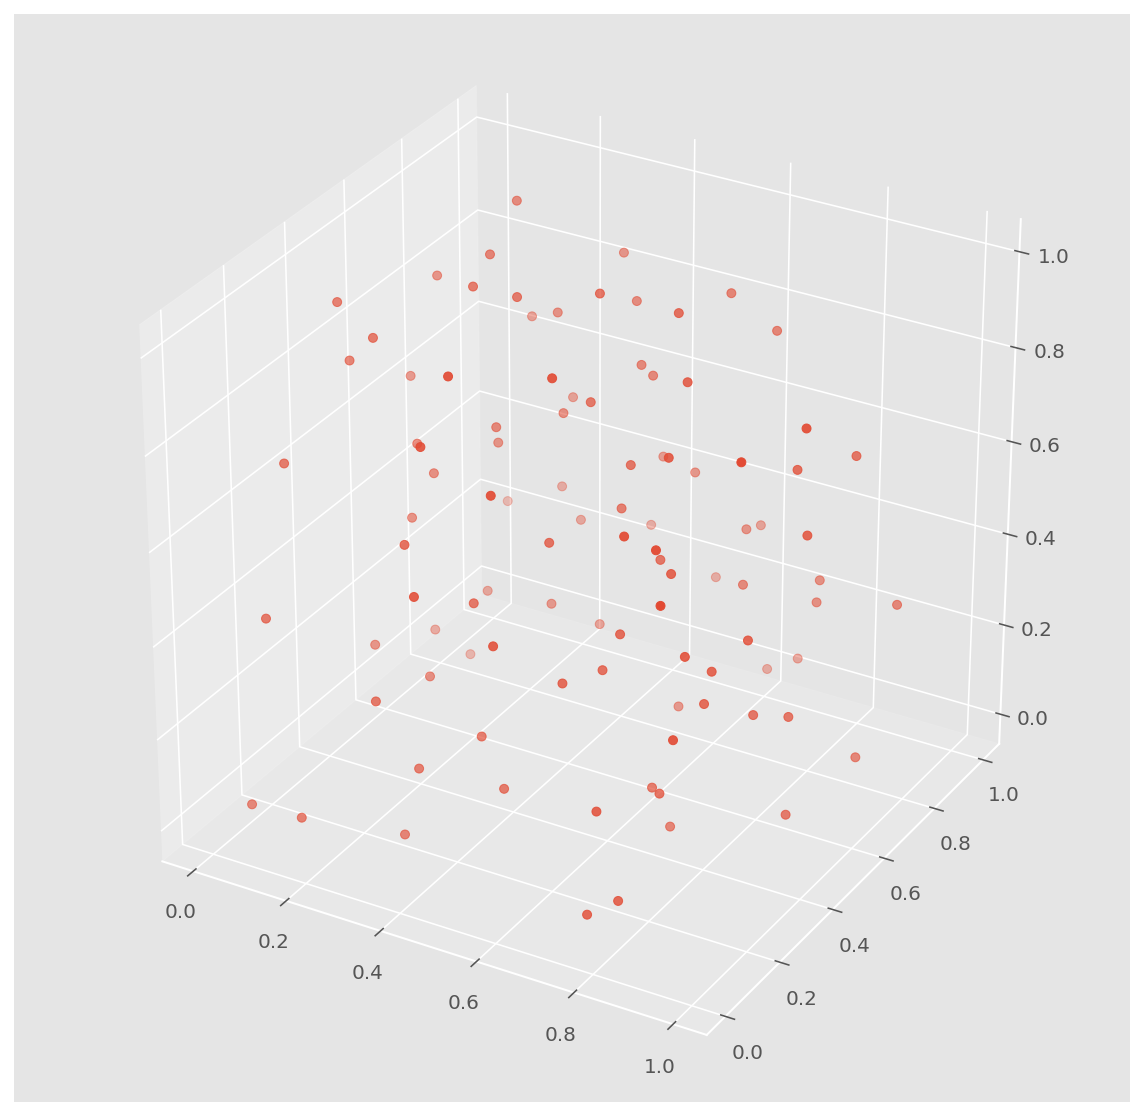

In [24]:
data = lhs(3, samples=100, criterion='center')
fig3 = plt.figure(figsize=(10,10))
ax3 = plt.axes(projection='3d')
x = data[:, 0]
y = data[:, 1]
z = data[:, 2]
ax3.scatter3D(x,y,z, cmap='b')
plt.show()

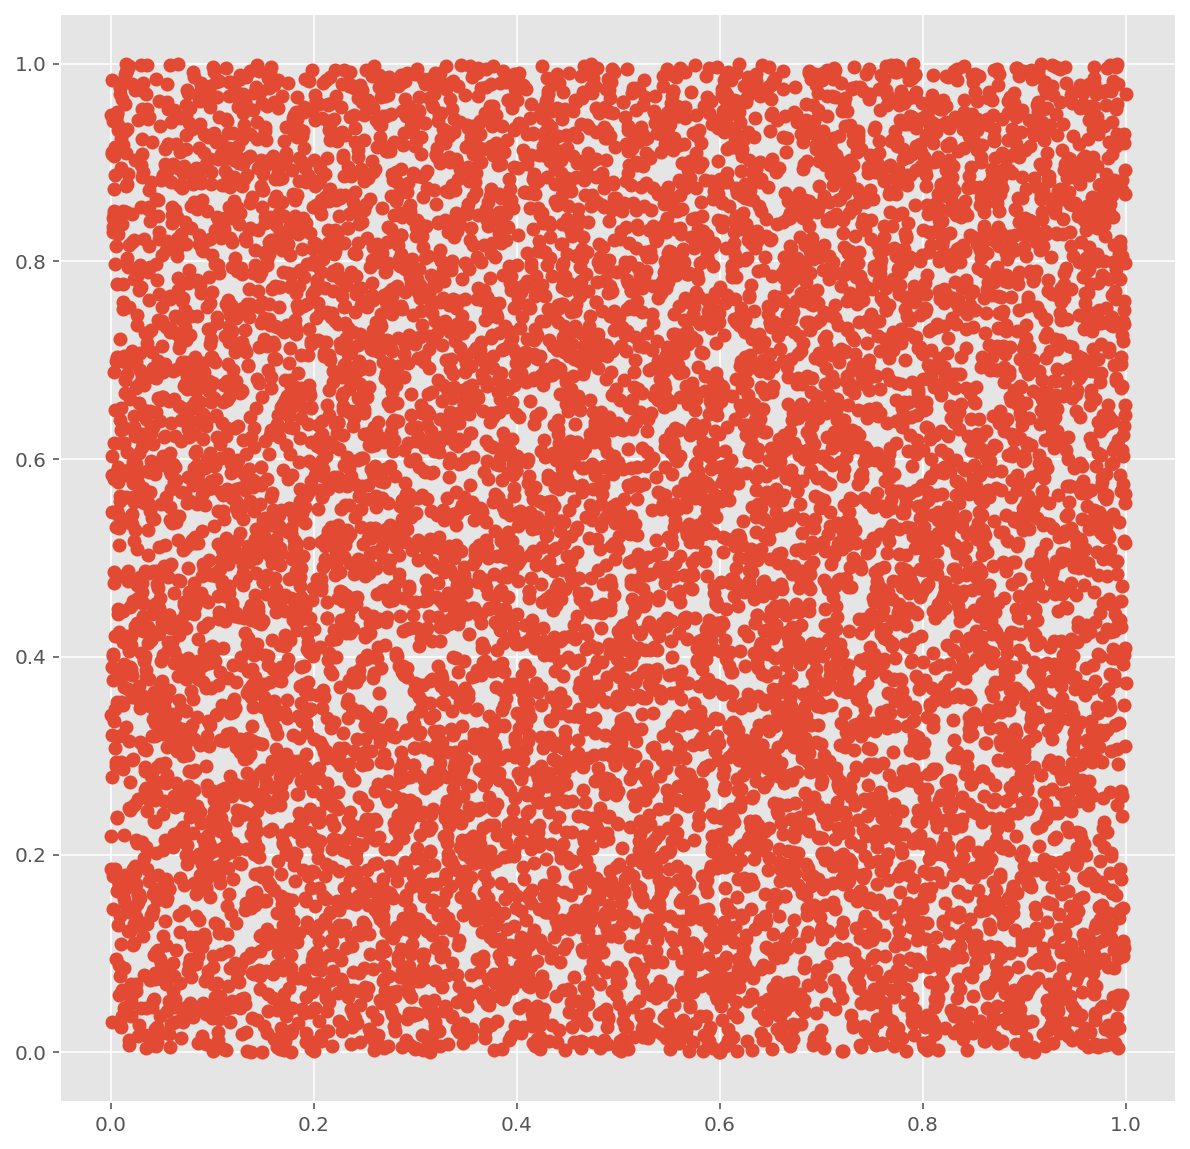

In [18]:
data = lhs(2, samples=10000, criterion='center')
plt.figure(figsize=(10, 10))
plt.plot(data[:, 0], data[:, 1], 'o')

In [8]:
from scipy.stats import qmc
sampler = qmc.LatinHypercube(d=2)
sample = sampler.random(n=5)
sample

ImportError: cannot import name 'qmc' from 'scipy.stats' (/Users/hubble/opt/anaconda3/lib/python3.7/site-packages/scipy/stats/__init__.py)

In [ ]:
# 对 train 做一个数据增强，边界点必须要加入，起码加进去两个0点和1个最大点

In [51]:
[v[-1] for v in unique_intervals.values()]

[14.4, 2.33, 1.76]

In [53]:
m.inference(np.array([[0, 14.4, 0, 2.33, 0, 1.76]])) * n_row

array([[6324.956]], dtype=float32)

In [5]:
m.inference(np.array([[0,0]]))

array([[0.01922894]], dtype=float32)

In [6]:
m.inference(np.array([[0,14.7]]))

array([[0.99593234]], dtype=float32)

In [7]:
m.inference(np.array([[2,14.7]]))

array([[0.99590474]], dtype=float32)

In [8]:
train_X

array([[ 0. ,  4.7],
       [ 0. ,  4.8],
       [ 0. ,  4.9],
       ...,
       [13.4, 16.9],
       [13.4, 16.9],
       [13.7, 16.9]], dtype=float32)

In [9]:
train_Y

array([[0.00246268],
       [0.00384793],
       [0.00507927],
       ...,
       [0.00277051],
       [0.00277051],
       [0.00230876]], dtype=float32)

In [10]:
pred = m.inference(grid)
#m.plotting(grid, pred)

In [11]:
# 增加边界点，看看对比的效果
# 增加epoch，看看误差和图形效果
# 增加query size，看看误差和效果

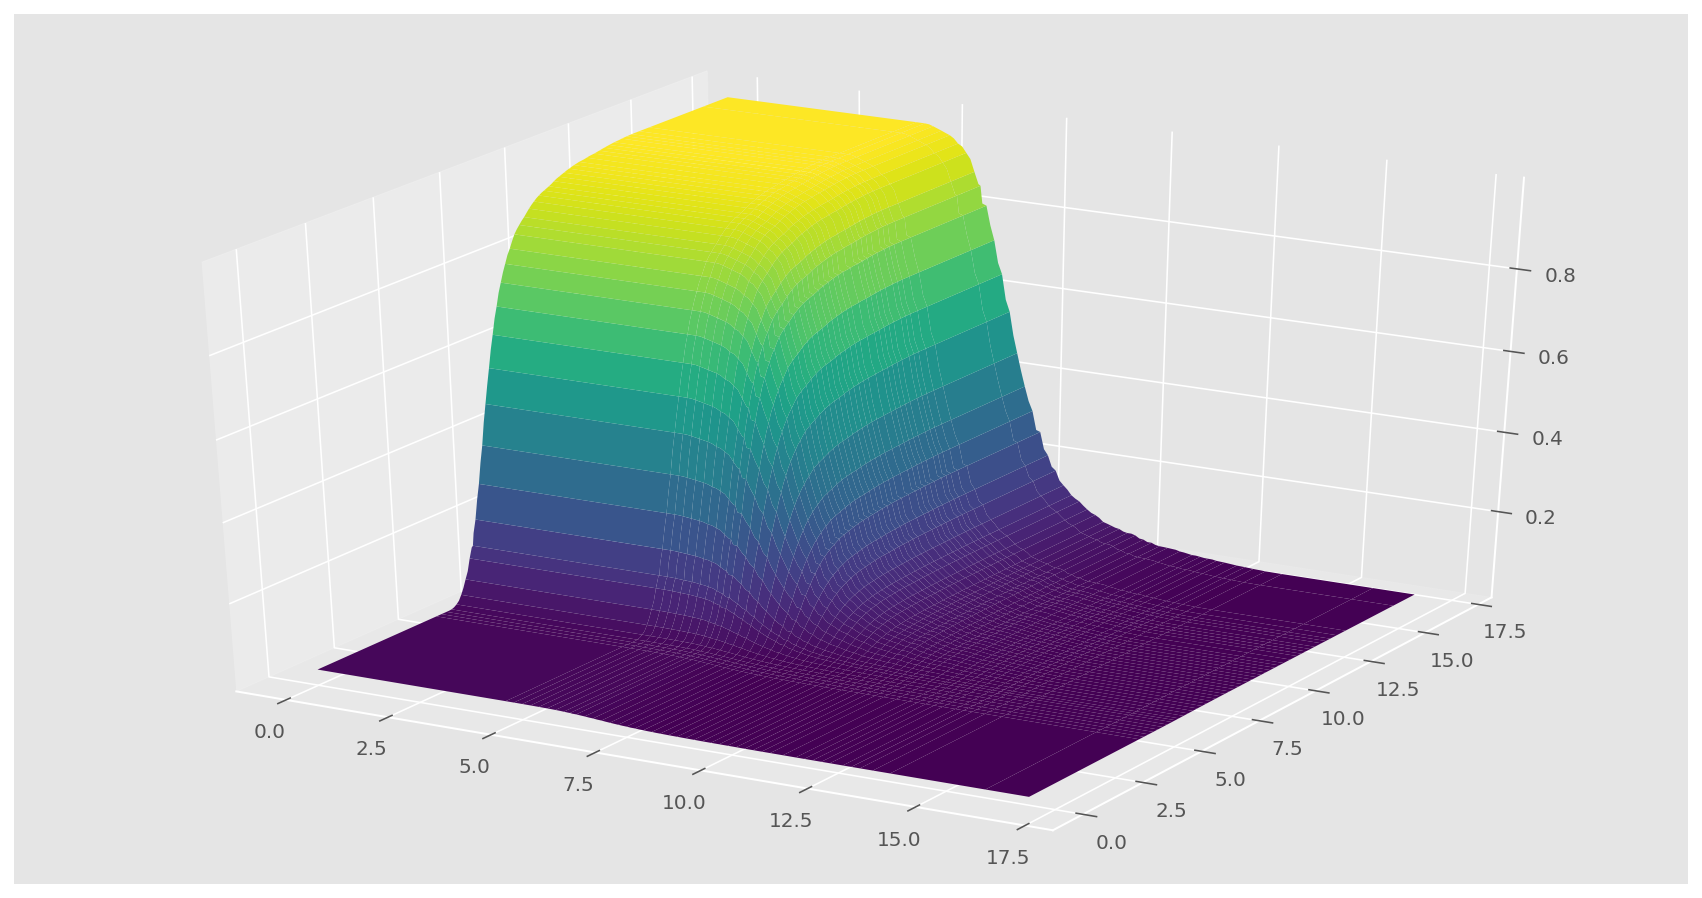

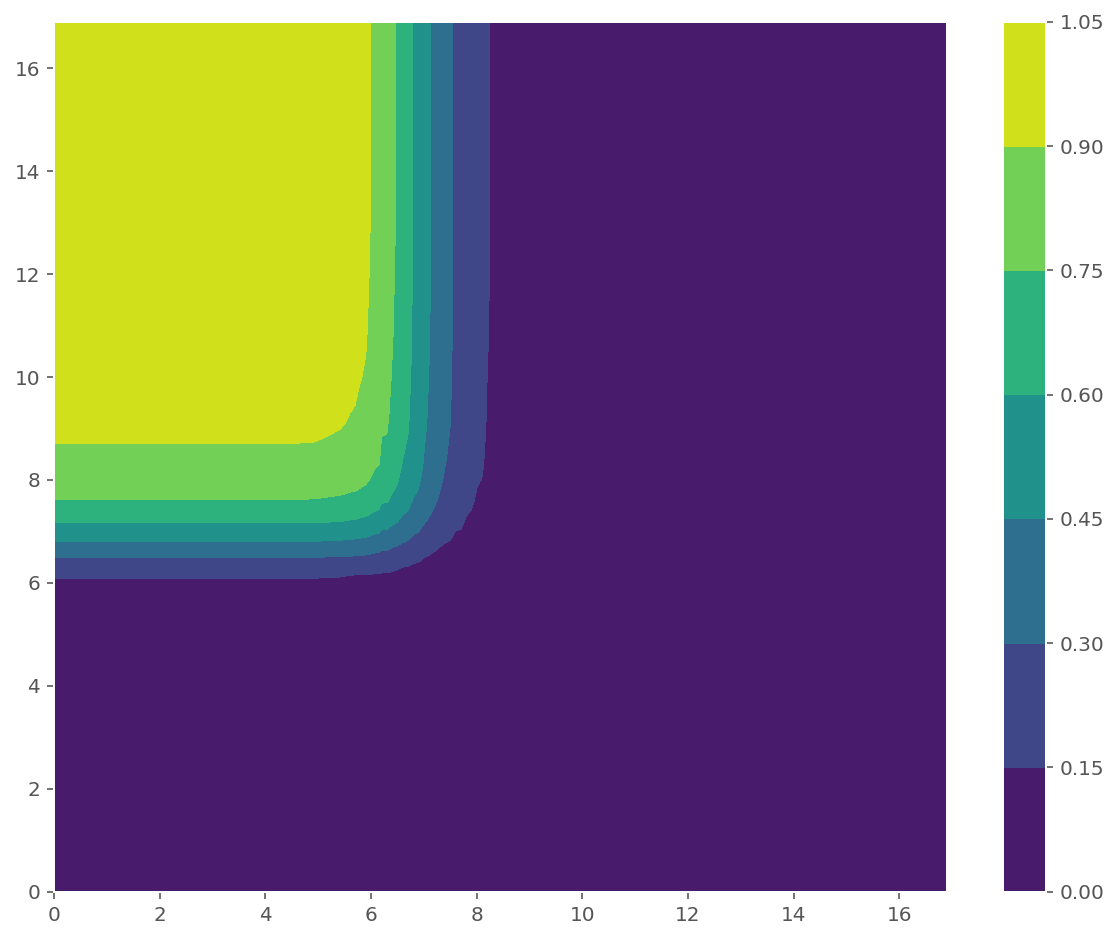

In [12]:
Xshape = len(np.unique(grid[:, 0]))
Yshape = len(np.unique(grid[:, 1]))
X = grid[:, 0].reshape(Xshape, Yshape)
Y = grid[:, 1].reshape(Xshape, Yshape)
Z = pred.reshape(Xshape, Yshape)

fig1 = plt.figure(figsize=(15, 8))
ax1 = plt.axes(projection='3d')
ax1.plot_surface(X, Y, Z, cmap='viridis')
plt.show()

fig2 = plt.figure(figsize=(10, 8))
ax2 = fig2.add_subplot(111)
cs = ax2.contourf(X, Y, Z, cmap='viridis')
# Alternatively, you can manually set the levels
# and the norm:
# lev_exp = np.arange(np.floor(np.log10(z.min())-1),
#                    np.ceil(np.log10(z.max())+1))
# levs = np.power(10, lev_exp)
# cs = ax.contourf(X, Y, z, levs, norm=colors.LogNorm())    # ??
cbar = fig2.colorbar(cs)  # 让colorbar细粒度更高一点
plt.show()